In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_parquet('./datasets/bechdel_ratings.parquet')
df = df.rename(columns={'rating': 'bechdel_rating'})
df.to_parquet('./datasets/bechdel_ratings.parquet', index=False)

In [13]:
ratings_df = pd.read_parquet('./datasets/avg_ratings.parquet')

df['imdb_id'] = df['imdb_id'].astype(str)
ratings_df['imdb_id'] = ratings_df['imdb_id'].astype(str).str.zfill(7)

movies_w_ratings = ratings_df.merge(df[["imdb_id", "bechdel_rating"]], on="imdb_id", how="left")
print(movies_w_ratings.head(50))

    movieId  imdb_id    rating  bechdel_rating
0         1  0114709  3.888157             1.0
1         2  0113497  3.236953             3.0
2         3  0113228  3.175550             3.0
3         4  0114885  2.875713             2.0
4         6  0113277  3.841764             2.0
5         7  0114319  3.372105             3.0
6        10  0113189  3.431841             3.0
7        11  0112346  3.660591             3.0
8        12  0112896  2.672179             3.0
9        13  0112453  3.326442             2.0
10       15  0112760  2.727040             1.0
11       16  0112641  3.795511             2.0
12       17  0114388  3.952227             3.0
13       18  0113101  3.409031             3.0
14       19  0112281  2.633983             0.0
15       22  0112722  3.300608             3.0
16       23  0112401  3.157631             1.0
17       25  0113627  3.667513             2.0
18       26  0114057  3.614058             2.0
19       27  0114011  3.424865             3.0
20       28  

In [28]:
passing_movies = movies_w_ratings[movies_w_ratings['bechdel_rating'] >= 3]
failing_movies = movies_w_ratings[movies_w_ratings['bechdel_rating'] < 3]

print("Summary stats of passing movies")
print("mean:", np.mean(passing_movies["rating"]))
print("median:", np.median(passing_movies["rating"]))
print("mode:", passing_movies["rating"].mode()[0])
print("std deviation:", np.std(passing_movies["rating"]))

print(" ")
print("Summary stats of failing movies")
print("mean:", np.mean(failing_movies["rating"]))
print("median:", np.median(failing_movies["rating"]))
print("mode:", failing_movies["rating"].mode()[0])
print("std deviation:", np.std(failing_movies["rating"]))

Summary stats of passing movies
mean: 3.2492940652732845
median: 3.325911875250389
mode: 3.5
std deviation: 0.5242898415372204
 
Summary stats of failing movies
mean: 3.308254439030753
median: 3.375
mode: 3.0
std deviation: 0.5340383804647884


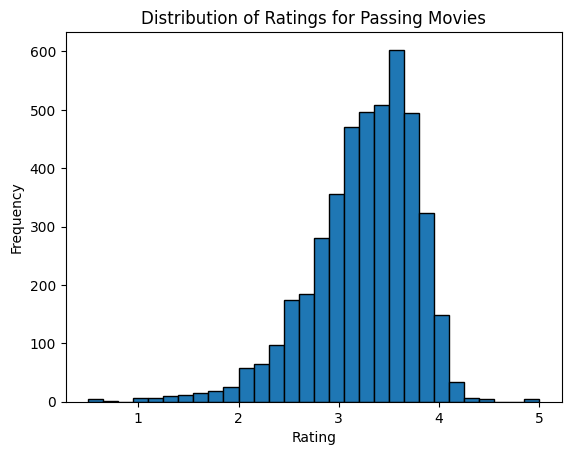

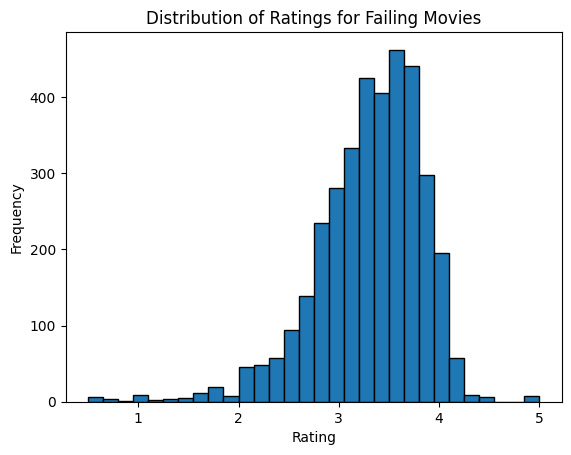

In [29]:
passing_movies['rating'].plot(kind='hist', bins=30, edgecolor='black')

plt.title('Distribution of Ratings for Passing Movies')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

failing_movies['rating'].plot(kind='hist', bins=30, edgecolor='black')

plt.title('Distribution of Ratings for Failing Movies')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()